In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

In [3]:
dataPath ='/content/drive/MyDrive/ProjectData/fer2013/fer2013.csv'

In [4]:
data = pd.read_csv(dataPath)

In [5]:
print(len(data[data['Usage']=='Training']))
print(len(data[data['Usage']=='PublicTest']))
print(len(data[data['Usage']=='PrivateTest']))

28709
3589
3589


In [6]:
Labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
Labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [7]:
trainData = data[data['Usage']=='Training']
validationData = data[data['Usage']=='PublicTest']
validationData = validationData.reset_index(drop=True) 
testData = data[data['Usage']=='PrivateTest']
testData = testData.reset_index(drop = True)

In [8]:
def show_example(df, num):
    print('expression: ' ,df.iloc[num] )
    image = np.array([[int(i) for i in x.split()] for x in df.loc[num, ['pixels']]])
    print(image.shape)
    image = image.reshape(48,48)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

expression:  emotion                                                    0
pixels     151 150 147 155 148 133 111 140 170 174 182 15...
Usage                                               Training
Name: 1, dtype: object
(1, 2304)


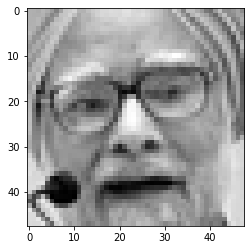

In [9]:
show_example(trainData, 1)

In [10]:
class converter(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        image, label = np.array([x.split() for x in self.df.loc[index, ['pixels']]]), row['emotion']
        image = np.asarray(image).astype(np.uint8).reshape(48,48,1)        
        if self.transforms:
            image = self.transforms(image)           
        return image.clone().detach(), label

In [11]:
# stats = ([0.5],[0.5])

In [12]:
trainTransformation = T.Compose([   
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
    T.Normalize(*([0.5],[0.5]),inplace=True), 
    # T.Normalize(*stats,inplace=True), 
])
validTransformation = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(), 
    T.Normalize(*([0.5],[0.5]),inplace=True)
])

In [13]:
trainDataSet = converter(trainData, trainTransformation)
validationDataSet = converter(validationData, validTransformation)
testDataSet = converter(testData, validTransformation)

In [14]:
# batch_size = 256

In [15]:
trainDataLoader = DataLoader(trainDataSet, 256, shuffle=True, num_workers=1, pin_memory=True)
validationDataLoader = DataLoader(validationDataSet, 256*2, num_workers=1, pin_memory=True)
testDataLoader = DataLoader(testDataSet, 256*2, num_workers=1, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


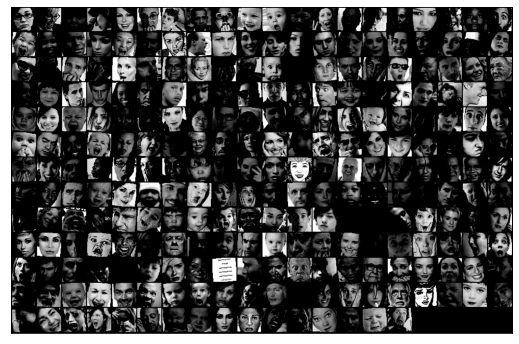

In [16]:
def display(dataLoader):
    for images, labels in dataLoader:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
        
display(trainDataLoader)

In [17]:
input_size = 48*48
output_size = len(Labels)

In [18]:
# evaluation metric
def accuracy(output, labels):
    predictions, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [19]:
class Model(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'Loss': loss.detach(), 'Accuracy': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch[{}], Loss: {:.4f}, Accuracy: {:.4f}".format(epoch+1, result['Loss'], result['Accuracy']))

In [20]:
torch.cuda.is_available()

True

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Some Helper function to see our models performance

In [24]:
trainDataLoader = DeviceDataLoader(trainDataLoader, device)
validationDataLoader = DeviceDataLoader(validationDataLoader, device)
testDataLoader = DeviceDataLoader(testDataLoader, device)

In [25]:
simple_model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [26]:
for images, labels in trainDataLoader:
    print('images.shape:', images.shape)
    simple_model.cuda()
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([256, 1, 48, 48])
out.shape: torch.Size([256, 8, 24, 24])


In [27]:
class emotion(Model):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 24 x 24

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 12 x 12

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 6 x 6

            nn.Flatten(), 
            nn.Linear(256*6*6, 2304),
            nn.ReLU(),
            nn.Linear(2304, 1152),
            nn.ReLU(),
            nn.Linear(1152, 576),
            nn.ReLU(),
            nn.Linear(576,288),
            nn.ReLU(),
            nn.Linear(288,144),
            nn.ReLU(),
            nn.Linear(144,7))
        
    def forward(self, xb):
        return self.network(xb)

In [28]:
model = to_device(emotion(), device)
model

emotion(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Flatten(start_dim=1, end_dim=-1)
    (18): Linear(in_fea

In [29]:
@torch.no_grad()
def evaluate(model, valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, valid_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        trainLoss = []
        for batch in train_dl:
            loss = model.training_step(batch)
            trainLoss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_dl)
        result['train_loss'] = torch.stack(trainLoss).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
epochs = 12
optimiser = torch.optim.Adam
learningRate = 0.001
history = fit(epochs, learningRate, model, trainDataLoader, validationDataLoader, optimiser)

Epoch[1], Loss: 1.7884, Accuracy: 0.2433
Epoch[2], Loss: 1.7496, Accuracy: 0.2755
Epoch[3], Loss: 1.5924, Accuracy: 0.3780
Epoch[4], Loss: 1.4575, Accuracy: 0.3719
Epoch[5], Loss: 1.3872, Accuracy: 0.4221
Epoch[6], Loss: 1.3268, Accuracy: 0.4602
Epoch[7], Loss: 1.2733, Accuracy: 0.5101
Epoch[8], Loss: 1.2664, Accuracy: 0.5162
Epoch[9], Loss: 1.2340, Accuracy: 0.5119
Epoch[10], Loss: 1.1640, Accuracy: 0.5503
Epoch[11], Loss: 1.1622, Accuracy: 0.5268
Epoch[12], Loss: 1.1314, Accuracy: 0.5371


In [31]:
def plot_accuracies(history):
    accuracies = [x['Accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

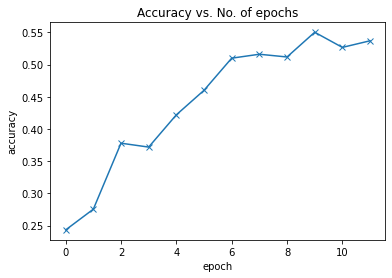

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['Loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

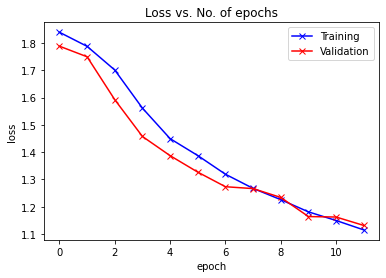

In [34]:
plot_losses(history)

### TESTING on test dataset.

In [35]:
result = evaluate(model, testDataLoader)
result

{'Accuracy': 0.574755847454071, 'Loss': 1.0993525981903076}

Testing this on our test expressions. 

In [36]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return Labels[preds[0].item()]

In [37]:
device

device(type='cuda')

Label: Angry , Predicted: Angry


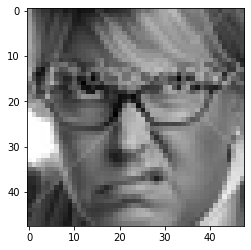

In [38]:
img, label = testDataSet[0]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)


print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

Label: Angry , Predicted: Angry


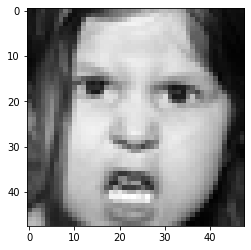

In [39]:
img, label = testDataSet[110]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

Label: Happy , Predicted: Happy


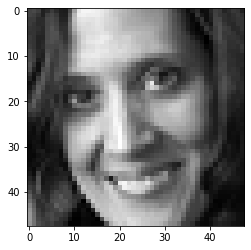

In [40]:
img, label = testDataSet[900]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))